In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

# NDVI

In [3]:
# --------*-*-*-*-*-*--------  HANTS code  --------*-*-*-*-*-*--------  HANTS code  --------*-*-*-*-*-*-----

# Computing diagonal for each row of a 2d array. See: http://stackoverflow.com/q/27214027/2459096
def makediag3d(M):
    b = np.zeros((M.shape[0], M.shape[1] * M.shape[1]))
    b[:, ::M.shape[1] + 1] = M
    return b.reshape(M.shape[0], M.shape[1], M.shape[1]) 

def get_starter_matrix(base_period_len, sample_count, frequencies_considered_count):
    nr = min(2 * frequencies_considered_count + 1,
                  sample_count)  # number of 2*+1 frequencies, or number of input images
    mat = np.zeros(shape=(nr, sample_count))
    mat[0, :] = 1
    ang = 2 * np.pi * np.arange(base_period_len) / base_period_len
    cs = np.cos(ang)
    sn = np.sin(ang)
    # create some standard sinus and cosinus functions and put in matrix
    i = np.arange(1, frequencies_considered_count + 1)
    ts = np.arange(sample_count)
    for column in xrange(sample_count):
        index = np.mod(i * ts[column], base_period_len)
        # index looks like 000, 123, 246, etc, until it wraps around (for len(i)==3)
        mat[2 * i - 1, column] = cs.take(index)
        mat[2 * i, column] = sn.take(index)

    return mat        

def HANTS(sample_count, inputs,
          frequencies_considered_count=3,
          outliers_to_reject='Hi',
          low=0., high=255,
          fit_error_tolerance=5,
          delta=0.1, 
          base=2):
    """
    Function to apply the Harmonic analysis of time series applied to arrays

    sample_count    = nr. of images (total number of actual samples of the time series)
    base_period_len    = length of the base period, measured in virtual samples
            (days, dekads, months, etc.)
    frequencies_considered_count    = number of frequencies to be considered above the zero frequency
    inputs     = array of input sample values (e.g. NDVI values)
    ts    = array of size sample_count of time sample indicators
            (indicates virtual sample number relative to the base period);
            numbers in array ts maybe greater than base_period_len
            If no aux file is used (no time samples), we assume ts(i)= i,
            where i=1, ..., sample_count
    outliers_to_reject  = 2-character string indicating rejection of high or low outliers
            select from 'Hi', 'Lo' or 'None'
    low   = valid range minimum
    high  = valid range maximum (values outside the valid range are rejeced
            right away)
    fit_error_tolerance   = fit error tolerance (points deviating more than fit_error_tolerance from curve
            fit are rejected)
    dod   = degree of overdeterminedness (iteration stops if number of
            points reaches the minimum required for curve fitting, plus
            dod). This is a safety measure
    delta = small positive number (e.g. 0.1) to suppress high amplitudes
    base  = define the base period, default is 1, meaning it is equal to size as the input 
            values, if 2 it will double this period. So for annual series, the base period becomes
            two years
    """

    # define some parameters
    if base == 1:
        base_period_len = sample_count  #
    if base == 2:
        base_period_len = sample_count*2  #

    # check which setting to set for outlier filtering
    if outliers_to_reject == 'Hi':
        sHiLo = -1
    elif outliers_to_reject == 'Lo':
        sHiLo = 1
    else:
        sHiLo = 0

    nr = min(2 * frequencies_considered_count + 1,
             sample_count)  # number of 2*+1 frequencies, or number of input images

    # create empty arrays to fill
    outputs = np.zeros(shape=(inputs.shape[0], sample_count))

    mat = get_starter_matrix(base_period_len, sample_count, frequencies_considered_count)

    # repeat the mat array over the number of arrays in inputs
    # and create arrays with ones with shape inputs where high and low values are set to 0
    mat = np.tile(mat[None].T, (1, inputs.shape[0])).T
    p = np.ones_like(inputs)
    p[(low >= inputs) | (inputs > high)] = 0
    nout = np.sum(p == 0, axis=-1)  # count the outliers for each timeseries

    # prepare for while loop
    ready = np.zeros((inputs.shape[0]), dtype=bool)  # all timeseries set to false

    dod = 1  # (2*frequencies_considered_count-1)  # Um, no it isn't :/
    noutmax = sample_count - nr - dod
    # prepare to add delta to suppress high amplitudes but not for [0,0]
    Adelta = np.tile(np.diag(np.ones(nr))[None].T, (1, inputs.shape[0])).T * delta
    Adelta[:, 0, 0] -= delta
    
    for _ in xrange(sample_count):
        if ready.all():
            break
        # print '--------*-*-*-*',it.value, '*-*-*-*--------'
        # multiply outliers with timeseries
        za = np.einsum('ijk,ik->ij', mat, p * inputs)

        # multiply mat with the multiplication of multiply diagonal of p with transpose of mat
        diag = makediag3d(p)
        A = np.einsum('ajk,aki->aji', mat, np.einsum('aij,jka->ajk', diag, mat.T))
        # add delta to suppress high amplitudes but not for [0,0]
        A += Adelta
        #A[:, 0, 0] = A[:, 0, 0] - delta

        # solve linear matrix equation and define reconstructed timeseries
        zr = np.linalg.solve(A, za)
        outputs = np.einsum('ijk,kj->ki', mat.T, zr)

        # calculate error and sort err by index
        err = p * (sHiLo * (outputs - inputs))
        rankVec = np.argsort(err, axis=1, )

        # select maximum error and compute new ready status
        maxerr = np.max(err, axis=-1)
        #maxerr = np.diag(err.take(rankVec[:, sample_count - 1], axis=-1))
        ready = (maxerr <= fit_error_tolerance) | (nout == noutmax)

        # if ready is still false
        if not ready.all():
            j = rankVec.take(sample_count - 1, axis=-1)

            p.T[j.T, np.indices(j.shape)] = p.T[j.T, np.indices(j.shape)] * ready.astype(
                int)  #*check
            nout += 1

    return outputs


# Compute semi-random time series array with numb standing for number of timeseries
def array_in(numb):
    y = np.array([5.0, 2.0, 10.0, 12.0, 18.0, 23.0, 27.0, 40.0, 60.0, 70.0, 90.0, 160.0, 190.0,
                  210.0, 104.0, 90.0, 170.0, 50.0, 120.0, 60.0, 40.0, 30.0, 28.0, 24.0, 15.0,
                  10.0])
    y = np.tile(y[None].T, (1, numb)).T
    kl = (np.random.randint(2, size=(numb, 26)) *
          np.random.randint(2, size=(numb, 26)) + 1)
    kl[kl == 2] = 0
    y = y * kl
    return y

In [4]:
file_in = r'D:\Downloads\ZhouJie@Mattijn//MODIS-8day-ndvi_2.xlsx'
df_myd = pd.read_excel(file_in, sheetname=0, header=0)
df_mod = pd.read_excel(file_in, sheetname=1, header=0)

In [5]:
timestamps = []
for idx, val in enumerate(df_myd['system:index']):
    year = val[-12:-8]
    month = val[-7:-5]
    day = val[-4:-2]
    #print i[-4:-2]
    #pd.Timestamp()
    date = pd.Timestamp(year+'-'+month+'-'+day)
    timestamps.append(date)
    #df['system:index'][idx] = date
df_myd['timestamps'] = timestamps    
#df_myd = df_myd.set_index(['timestamps','LC_type'])

timestamps = []
for idx, val in enumerate(df_mod['system:index']):
    year = val[-12:-8]
    month = val[-7:-5]
    day = val[-4:-2]
    #print i[-4:-2]
    #pd.Timestamp()
    date = pd.Timestamp(year+'-'+month+'-'+day)
    timestamps.append(date)
    #df['system:index'][idx] = date
df_mod['timestamps'] = timestamps    
#df_mod = df_mod.set_index(['timestamps','LC_type'])
df_mod_myd = pd.concat([df_mod,df_myd])
df_mod_myd.set_index(['timestamps','LC_type'], inplace=True)
df_mod_myd.sortlevel(inplace=True)

In [6]:
# Rainfed_croplands
df_RC = df_mod_myd.loc[df_mod_myd.index.get_level_values('LC_type') == 'Rainfed_croplands']
df_RC.reset_index(inplace=True)
df_RC.set_index('timestamps', inplace=True)

# Mosaic_cropland_vegetation
df_MC = df_mod_myd.loc[df_mod_myd.index.get_level_values('LC_type') == 'Mosaic_cropland_vegetation']
df_MC.reset_index(inplace=True)
df_MC.set_index('timestamps', inplace=True)

# Mosaic_cropland_vegetation
df_MC = df_mod_myd.loc[df_mod_myd.index.get_level_values('LC_type') == 'Mosaic_cropland_vegetation']
df_MC.reset_index(inplace=True)
df_MC.set_index('timestamps', inplace=True)

# Mosaic_vegetation_cropland
df_MV = df_mod_myd.loc[df_mod_myd.index.get_level_values('LC_type') == 'Mosaic_vegetation_cropland']
df_MV.reset_index(inplace=True)
df_MV.set_index('timestamps', inplace=True)

# Open_needleleaved_deciduous_evergreen_forest
df_ON = df_mod_myd.loc[df_mod_myd.index.get_level_values('LC_type') == 'Open_needleleaved_deciduous_evergreen_forest']
df_ON.reset_index(inplace=True)
df_ON.set_index('timestamps', inplace=True)

# Closed_to_open_herbaceous_vegetation
df_CO = df_mod_myd.loc[df_mod_myd.index.get_level_values('LC_type') == 'Closed_to_open_herbaceous_vegetation']
df_CO.reset_index(inplace=True)
df_CO.set_index('timestamps', inplace=True)

# Sparse_vegetation
df_SV = df_mod_myd.loc[df_mod_myd.index.get_level_values('LC_type') == 'Sparse_vegetation']
df_SV.reset_index(inplace=True)
df_SV.set_index('timestamps', inplace=True)

# Bare_areas
df_BA = df_mod_myd.loc[df_mod_myd.index.get_level_values('LC_type') == 'Bare_areas']
df_BA.reset_index(inplace=True)
df_BA.set_index('timestamps', inplace=True)

In [7]:
np.unique(df_mod_myd.index.get_level_values('LC_type'))

array([u'Bare_areas', u'Closed_to_open_herbaceous_vegetation',
       u'Mosaic_cropland_vegetation', u'Mosaic_vegetation_cropland',
       u'Open_needleleaved_deciduous_evergreen_forest',
       u'Rainfed_croplands', u'Sparse_vegetation'], dtype=object)

In [8]:
# get all unique years in the range
un_years = np.unique(df_mod_myd.index.get_level_values('timestamps').year)
un_years

array([2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014])

In [9]:
# for i in un_years:
#     period = str(i)
#     df_RC['NDVI'][period].plot(style='-', label = 'RC', legend=True)
#     df_MC['NDVI'][period].plot(style='-', label = 'MC', legend=True)
#     df_MV['NDVI'][period].plot(style='-', label = 'MV', legend=True)
#     df_ON['NDVI'][period].plot(style='-', label = 'ON', legend=True)
#     df_CO['NDVI'][period].plot(style='-', label = 'CO', legend=True)
#     df_SV['NDVI'][period].plot(style='-', label = 'SV', legend=True)
#     df_BA['NDVI'][period].plot(style='-', label = 'BA', legend=True)
#     plt.show()

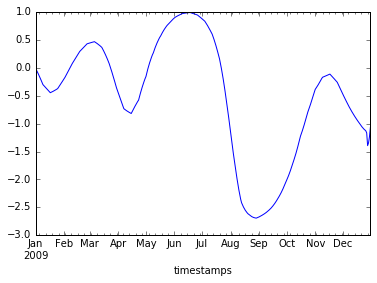

In [10]:
# create empty pandas series to append later on
ts_RC = pd.Series()
# apply hants for each year separated
for i in un_years:    
    period = str(i)
    # do hants for period for land cover type:
    # RC
    y_RC = df_RC['NDVI'][period].as_matrix()[None]
    y_RC_HANTS = HANTS(y_RC.shape[-1], y_RC, 6, outliers_to_reject='Lo', low=-2000, 
                       high = 10000, fit_error_tolerance=500, base = 2)
    
    #print df_RC['NDVI'][period].index
    #print y_RC_HANTS[0]
    # convert output to timeseries of single year and append to ts_RC
    ts_RC_period = pd.Series(y_RC_HANTS[0], index=df_RC['NDVI'][period].index)
    ts_RC = ts_RC.append(ts_RC_period)
    
# # visually compare original with hants reconstructed
# df_RC['NDVI'].plot()
# ts_RC.plot()

# resample the 8 day values to daily values and linearly interpolate in between
ts_RC = ts_RC.resample('d')
ts_RC.interpolate(inplace=True)
# calculate the svi through some fancy oneliner
svi_RC = ts_RC.groupby([ts_RC.index.month, ts_RC.index.day]).apply(lambda g: (g - g.mean())/g.std())
# plot the svi for period 2009
#svi_RC['2009'].as_matrix()
svi_RC['2009'].plot()

In [11]:
svi_RC['2009'].head()

timestamps
2009-01-01   -0.007867
2009-01-02   -0.040875
2009-01-03   -0.075000
2009-01-04   -0.110217
2009-01-05   -0.146491
Freq: D, dtype: float64

In [12]:
list_df = [df_RC,df_MC,df_MV,df_ON,df_CO,df_SV,df_BA]
land_tp = ['RC','MC','MV','ON','CO','SV','BA']

In [13]:
df_shp = pd.DataFrame(index=svi_RC['2009'].index, columns=land_tp)
df_shp.head()

,RC,MC,MV,ON,CO,SV,BA
timestamps,,,,,,,
2009-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
for idx, df_LC in enumerate(list_df):
    #print df_LC.head()
    LC = land_tp[idx]
    print LC
    # create empty pandas series to append later on
    ts_LC = pd.Series()
    # apply hants for each year separated
    for i in un_years:    
        period = str(i)
        # do hants for period for land cover type:
        # RC
        y_LC = df_LC['NDVI'][period].as_matrix()[None]
        y_LC_HANTS = HANTS(y_LC.shape[-1], y_LC, 6, outliers_to_reject='Lo', low=-2000, 
                           high = 10000, fit_error_tolerance=500, base = 2)

        #print df_RC['NDVI'][period].index
        #print y_RC_HANTS[0]
        # convert output to timeseries of single year and append to ts_RC
        ts_LC_period = pd.Series(y_LC_HANTS[0], index=df_LC['NDVI'][period].index)
        ts_LC = ts_LC.append(ts_LC_period)

    # # visually compare original with hants reconstructed
    # df_RC['NDVI'].plot()
    # ts_RC.plot()

    # resample the 8 day values to daily values and linearly interpolate in between
    ts_LC = ts_LC.resample('d')
    ts_LC.interpolate(inplace = True)
    # calculate the svi through some fancy oneliner
    svi_LC = ts_LC.groupby([ts_LC.index.month, ts_LC.index.day]).apply(lambda g: (g - g.mean())/g.std())
    # plot the svi for period 2009
    #svi_RC['2009'].as_matrix()
    df_shp[LC] = svi_LC['2009']
    #svi_LC['2009'].plot()

RC
MC
MV
ON
CO
SV
BA


In [15]:
df_shp.head()

,RC,MC,MV,ON,CO,SV,BA
timestamps,,,,,,,
2009-01-01,-0.007867,0.116449,0.582571,-1.515537,0.767543,0.006135,-0.677043
2009-01-02,-0.040875,0.075006,0.500041,-1.507272,0.756857,0.063044,-0.613552
2009-01-03,-0.075000,0.034097,0.408546,-1.497159,0.745556,0.119482,-0.549928
2009-01-04,-0.110217,-0.006079,0.309630,-1.484950,0.733665,0.175244,-0.486383
2009-01-05,-0.146491,-0.045345,0.205665,-1.470371,0.721216,0.230142,-0.423121


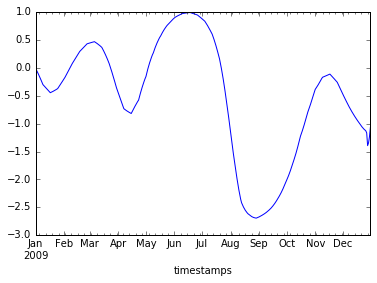

In [16]:
df_shp['RC'].plot()

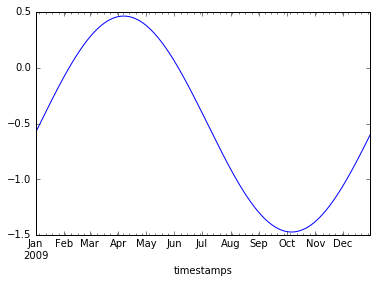

In [17]:
# from the svi extract a single year and get the annual component
period = '2009'
y1_RC = svi_RC[period].as_matrix()[None]
y1_RC_HANTS = HANTS(y1_RC.shape[-1], y1_RC, 1, outliers_to_reject='Lo', low=-2000, 
                    high = 10000, fit_error_tolerance=500, base=1)
ts1_RC_period = pd.Series(y1_RC_HANTS[0], index=svi_RC[period].index)
ts1_RC_period.plot()

In [19]:
y1_RC.size

365

In [20]:
y1_RC.shape[-1]

365L

# PRECIPITATION

In [21]:
from osgeo import gdal, ogr
import os
import subprocess as sp
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [22]:
def listall(RootFolder, varname='',extension='.png'):
    lists = [os.path.join(root, name)
             for root, dirs, files in os.walk(RootFolder)
             for name in files
             if varname in name
             if name.endswith(extension)]
    return lists

In [23]:
# 10_DAY_COMPOSITE PRECIPITATION ANOMALIY
# get index from tif files
files = listall(r'D:\Data\0_DAILY_INTERVAL_NDVI_TRMM\InnerMongolia\TRMM2_2009\10_Day_Period\10_DaySums_StdNormAnomalyRes', extension='.tif')
index = []
for i in files:
    # get date
    year = int(i[-11:-7])
    doy = int(i[-7:-4])
    date = datetime(year, 1, 1) + timedelta(doy - 1)
    date = pd.Timestamp(str(date.year)+'-'+str(date.month)+'-'+str(date.day))
    #date = np.datetime64(date)    
    #date = pd.Timestamp(np.datetime_as_string(date))
    index.append(date)
index = np.array(index)
print files[0], index[0]

D:\Data\0_DAILY_INTERVAL_NDVI_TRMM\InnerMongolia\TRMM2_2009\10_Day_Period\10_DaySums_StdNormAnomalyRes\TRMM_IM_2009001.tif 2009-01-01 00:00:00


In [24]:
# get columns from shp file
shp_filename = r'D:\Data\ChinaShapefile//LC_types.shp'
siteID_list = []
ds = ogr.Open(shp_filename)
lyr = ds.GetLayer()
for feat in lyr:
    # get siteID from Field
    siteID = str(feat.GetField('LC_typce'))
    siteID_list.append(siteID)
siteID_array = np.array(siteID_list)
columns = np.unique(siteID_array).astype(str)   

# create empty DataFrame
df = pd.DataFrame(index=index, columns=columns)
#df_shp = pd.DataFrame(index=index, columns=columns)
df.head()

,BA,CO,MC,MV,ON,RC,SV
2009-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
for i in files:
    # load raster GeoTransform, RasterBand    
    try:
        src_ds = gdal.Open(i) 
        gt = src_ds.GetGeoTransform()
        rb = src_ds.GetRasterBand(1)

        # get date
        year = int(i[-11:-7])
        doy = int(i[-7:-4])
        date = datetime(year, 1, 1) + timedelta(doy - 1)
        date = pd.Timestamp(str(date.year)+'-'+str(date.month)+'-'+str(date.day))
        #date = np.datetime64(date)
        #date = pd.Timestamp(np.datetime_as_string(date))
        print date
    except Exception, e:
        print e, i
        continue
        
    ds = ogr.Open(shp_filename)
    lyr = ds.GetLayer()
    for feat in lyr:
        try:
            # get siteID from Field

            siteID = str(feat.GetField('LC_typce'))
            #if siteID == '50353':

            # get lon/lat from GeometryRef
            geom = feat.GetGeometryRef()
            mx,my=geom.GetX(), geom.GetY()  #coord in map units

            # convert from map to pixel coordinates.    
            px = int((mx - gt[0]) / gt[1]) #x pixel
            py = int((my - gt[3]) / gt[5]) #y pixel

            # get single pixel
            pixel = rb.ReadAsArray(px,py,1,1)
            #array_ID_nine = np.ma.masked_equal(array_ID_nine, 0)
            #stationID_mean = np.ma.mean(array_ID_nine)
            # stationID_mean = np.nanmean(array_ID_nine)            
            # set pandas dataframe value
            df.ix[date][siteID] = pixel[0][0]
            #print siteID#, px, py, stationID_mean, df.ix[date][siteID]
        except Exception, e:
            #print e, i, feat.GetFID()
            continue

2009-01-01 00:00:00
2009-01-02 00:00:00
2009-01-03 00:00:00
2009-01-04 00:00:00
2009-01-05 00:00:00
2009-01-06 00:00:00
2009-01-07 00:00:00
2009-01-08 00:00:00
2009-01-09 00:00:00
2009-01-10 00:00:00
2009-01-11 00:00:00
2009-01-12 00:00:00
2009-01-13 00:00:00
2009-01-14 00:00:00
2009-01-15 00:00:00
2009-01-16 00:00:00
2009-01-17 00:00:00
2009-01-18 00:00:00
2009-01-19 00:00:00
2009-01-20 00:00:00
2009-01-21 00:00:00
2009-01-22 00:00:00
2009-01-23 00:00:00
2009-01-24 00:00:00
2009-01-25 00:00:00
2009-01-26 00:00:00
2009-01-27 00:00:00
2009-01-28 00:00:00
2009-01-29 00:00:00
2009-01-30 00:00:00
2009-01-31 00:00:00
2009-02-01 00:00:00
2009-02-02 00:00:00
2009-02-03 00:00:00
2009-02-04 00:00:00
2009-02-05 00:00:00
2009-02-06 00:00:00
2009-02-07 00:00:00
2009-02-08 00:00:00
2009-02-09 00:00:00
2009-02-10 00:00:00
2009-02-11 00:00:00
2009-02-12 00:00:00
2009-02-13 00:00:00
2009-02-14 00:00:00
2009-02-15 00:00:00
2009-02-16 00:00:00
2009-02-17 00:00:00
2009-02-18 00:00:00
2009-02-19 00:00:00


In [26]:
df_new = df[df.columns[0]].astype(float)
df_new = df_new.resample('H')
df_new.interpolate(inplace=True)

364

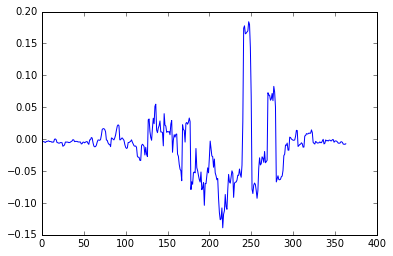

In [27]:
NDVI = df_shp['RC'].as_matrix()
P = df['BA'].as_matrix()
plt.plot(P)
P.size

In [28]:
y1_RC.max()*100

99.134343780422057

In [29]:
# from the svi extract a single year and get the annual component
y1_RC = P+1
y1_RC_HANTS = HANTS(y1_RC.size, y1_RC, 1, outliers_to_reject='Lo', low=-100, 
                    high = 100, fit_error_tolerance=0.5, base=1)
ts1_RC_period = pd.Series(y1_RC_HANTS[0], index=svi_RC[period].index)
ts1_RC_period.plot()

ValueError: einstein sum subscripts string contains too many subscripts for operand 1

# COMPUTE MULTITAPER + UNCERTAINTY

In [30]:
%matplotlib inline
from __future__ import division
from osgeo import gdal
import numpy as np
import scipy.signal
import os
import matplotlib.pyplot as plt
import nitime.algorithms as tsa
import random
import os
from osgeo import gdal
import scipy.signal
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

In [31]:
def dB(x, out=None):
    if out is None:
        return 10 * np.log10(x)
    else:
        np.log10(x, out)
        np.multiply(out, 10, out)
        
def mtem(x, y):
    """
    multitaper estimation method
    input:
    x  first time series
    y  second time series

    output:
    fkx  power spectral density x
    fky  power spectral density y
    cxy  cross-spectral density xy
    coh  coherence
    ph  phase between xy at input freq
    
    """
    print ('x size', x.shape)
    print ('y size', y.shape)
    
    # apply multi taper cross spectral density from nitime module
    f, pcsd_est = tsa.multi_taper_csd(np.vstack([x,y]), Fs=1., low_bias=True, adaptive=True, sides='onesided')
    
    # output is MxMxN matrix, extract the psd and csd
    fkx = pcsd_est.diagonal().T[0]
    fky = pcsd_est.diagonal().T[1]
    cxy = pcsd_est.diagonal(+1).T.ravel()
    
    # using complex argument of cxy extract phase component
    ph = np.angle(cxy)
    
    # calculate coherence using csd and psd
    coh = np.abs(cxy)**2 / (fkx * fky)   
    
    return f, fkx, fky, cxy, ph, coh 

def mtem_unct(x_, y_, cf, mc_no=20):
    """
    Uncertainty function using Monte Carlo analysis
    Input:
    x_ = timeseries x
    y_ = timeseries y
    cf = coherence function between x and y
    mc_no = number of iterations default is 20, minimum is 3
    
    Output:
    phif = phase uncertainty bounded between 0 and pi
    """
    print ('iteration no is', mc_no)
    
    data = np.vstack([x_,y_])
    # number of iterations
    # flip coherence and horizontal stack    
    cg = np.hstack((cf[:-1], np.flipud(cf[:-1])))
    
    # random time series fx
    mc_fx = np.random.standard_normal(size=(mc_no,len(data[0])))
    mc_fx = mc_fx / np.sum(abs(mc_fx),axis=1)[None].T
    
    # random time series fy
    mc_fy = np.random.standard_normal(size=(mc_no,len(data[0])))
    mc_fy = mc_fy / np.sum(abs(mc_fy),axis=1)[None].T
    
    # create semi random timeseries based on magnitude squared coherence
    # and inverse fourier transform for ys
    ys = np.real(np.fft.ifft(mc_fy * np.sqrt(1 - cg ** 2))) 
    ys = ys + np.real(np.fft.ifft(mc_fx *cg))
    
    # inverse fourier transform for xs
    xs = np.real(np.fft.ifft(mc_fx))
    
    # spectral analysis
    f_s, pcsd_est = tsa.multi_taper_csd(np.vstack([xs,ys]), Fs=1., low_bias=True, adaptive=True, sides='onesided')
    cxyi = pcsd_est.diagonal(+int(xs.shape[0])).T
    phi = np.angle(cxyi)
    
    # sort and average the highest uncertianties
    pl = int(round(0.975*mc_no)+1)
    phi = np.sort(phi,axis=0)        
    phi = phi[((mc_no+1)-pl):pl]
    phi = np.array([phi[pl-2,:],-phi[pl-mc_no,:]])
    phi = phi.mean(axis=0)#
    phi = np.convolve(phi, np.array([1,1,1])/3)
    phif = phi[1:-1]
    return phif

def pad_extend(m1, m2, tile_no=100, extend=0):
    """
    Input 'm1':
    Signal 1
    Input 'm2':
    Signal 2
    Input 'extend':
    0 = repeat signal
    1 = padd with zeroes left
    2 = padd with zeroes right
    3 = padd with zeroes on both sides
    Input 'tile_no':
    number of times to pad or extend the signal
    
    Output 
    x,y,t = repeated/padded signals + evenly spaced interval of the range
    """
    
    
    if extend == 0:
        x = np.tile(m1, tile_no+1)
        y = np.tile(m2, tile_no+1)
    elif extend == 1:
        x = np.lib.pad(m1, (len(m1)*(tile_no),0), 'constant', constant_values=0)
        y = np.lib.pad(m2, (len(m2)*(tile_no),0), 'constant', constant_values=0)    
    
    elif extend == 2:
        x = np.lib.pad(m1, (0,len(m1)*(tile_no)), 'constant', constant_values=0)
        y = np.lib.pad(m2, (0,len(m1)*(tile_no)), 'constant', constant_values=0)    
    
    elif extend == 3:
        x = np.lib.pad(m1, (len(m1)*tile_no/2,len(m1)*(tile_no/2)), 'constant', constant_values=0)
        y = np.lib.pad(m2, (len(m2)*tile_no/2,len(m1)*(tile_no/2)), 'constant', constant_values=0)    
    
    if len(x) % 2 != 0:
        x = x[:-1]
    
    if len(y) % 2 != 0:
        y = y[:-1]
        
    t = np.arange(x.shape[0])
    return x,y,t


def plotCrossSpectral(f,ph,coh,phif):
    plt.figure(figsize=(14,4.5))
    
    ## PLOT 5
    plt.subplot(121)
    
    plt.grid(axis='y')
    plt.plot(f,coh, 'y')
    
    plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.2)
    plt.axvspan(0.0054,0.0056, color='gray', alpha=0.2)
    plt.axvspan(0.0081,0.0083, color='gray', alpha=0.2)
    plt.axvspan(0.0108,0.0110, color='gray', alpha=0.2)
    
    plt.xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))],[str(0.0027),str(0.0055),str(0.0082),str(0.0109)])
    plt.xlim(xlim_start,xlim_end)
    plt.ylim(0,1.01)
    
    plt.ylabel('coherence')
    plt.xlabel('frequency (Hz)')
    plt.title('coherence x/y with repeated ts: '+str(tile_no))
    
    ## PLOT 9
    rad2time = ph/(2*np.pi*f)
    mtcl2time = phif/(2*np.pi*f)
    neg_time= np.where(rad2time<0)
    dur_cycl = (1/f)
    rad2time[neg_time] = rad2time[neg_time]+dur_cycl[neg_time]
    
    
    ax = host_subplot(122, axes_class=AA.Axes)
    
    p1 = plt.Rectangle((0, 0), 1, 1, fc='c', ec='c')
    p2, = ax.plot(f, rad2time, color='m', zorder=5, label='Phase')
    p3, = ax.plot(f, dur_cycl, color='gray', linestyle='-.', zorder=5, label='Period')
    p4, = ax.plot(f, dur_cycl/2, color='gray', linestyle='--', zorder=5, label='Halve period')
    
    ax.fill_between(f,(rad2time+mtcl2time),(rad2time-mtcl2time), where=(((rad2time+mtcl2time)<dur_cycl)), 
                 facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
    ax.fill_between(f,(rad2time-mtcl2time),dur_cycl, where=(((rad2time+mtcl2time)>dur_cycl)),
                 facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
    ax.fill_between(f,(rad2time+mtcl2time)-dur_cycl, where=(((rad2time+mtcl2time)>0)),
                 facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
    ax.fill_between(f,((rad2time-mtcl2time)+dur_cycl),dur_cycl, where=((rad2time-mtcl2time)<0), 
                 facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
    
    ax.set_xlim([xlim_start,xlim_end])
    ax.set_ylim([0,365])
    ax.set_xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))])
    ax.set_xticklabels([str(0.0027),str(0.0055),str(0.0082),str(0.0109)])
    
    ax.set_xlabel('frequency (Hz)')
    ax.set_ylabel('phase (day)')
    ax.set_title('t (month)', loc='left', fontsize=10)
    
    p5= plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.2, zorder=-1)
    plt.axvspan(0.0054,0.0056, color='gray', alpha=0.2)
    plt.axvspan(0.0081,0.0083, color='gray', alpha=0.2)
    plt.axvspan(0.0108,0.0110, color='gray', alpha=0.2)
    #axvspan(0.099,0.101, color='gray', alpha=0.1, zorder=0)
    
    ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
    ax2.set_xlabel('phase spectrum x/y + uncertainty')
    ax2.set_xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))])
    ax2.set_xticklabels([str(12),str(6),str(4),str(3)])
    ax2.axis["right"].major_ticklabels.set_visible(False)
    ax2.xaxis.label.set_size(2)
    
    
    lg = plt.legend([p3,p4], ['single period','halve period'], ncol=1)
    lg.get_frame().set_ec('lightgray')
    lg.get_frame().set_lw(0.5)
    plt.grid(axis='y', zorder=0 )
    
    plt.gcf().tight_layout()
    #plt.savefig(r'C:\Users\lenovo\Documents\HOME//nodetrending_2007_Wet_nohants.png', dpi=400)
    
    # frequency index
    #f_lb = 0.0054 # vspan_start 
    #f_ub = 0.0056 # vspan_end
    #f_ix = np.where((f > f_lb) * (f < f_ub))[0]
    #p_r2t = np.mean(rad2time[f_ix], -1)
    #p_ph = np.mean(ph[f_ix], -1)
    #print ('phase in radian is', round(p_ph,2))
    #print ('which correspond to', round(p_r2t,2), 'day')
    #plt.savefig(r'C:\Users\lenovo\Documents\HOME\2015-02-05_pics4progress//nodetrending_2006_Wet_nohants.png', dpi=400)
    plt.show()
    plt.close()

In [32]:
P_ = P - P.mean()
NDVI_ = NDVI[0:-1] - NDVI[0:-1].mean()

In [33]:
tile_no = 50
P__, NDVI__, t_ = pad_extend(P_, NDVI_, tile_no=tile_no, extend = 0)
x, y, t = pad_extend(P__, NDVI__, tile_no=1, extend = 3)

((37128L,), (37128L,))


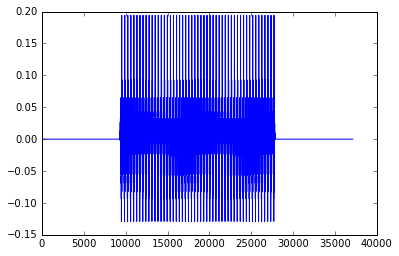

In [34]:
print (x.shape, y.shape)
plt.plot(x)

In [35]:
f, fkx, fky, cxy, ph, coh = mtem(x,y)
phif = mtem_unct(x,y,coh, mc_no=5)

('x size', (37128L,))
('y size', (37128L,))
('iteration no is', 5)


D:\Python27x64\lib\site-packages\nitime\utils.py:571: RuntimeWarning: Breaking due to iterative meltdown in nitime.utils.adaptive_weights.
  warnings.warn(e_s, RuntimeWarning)


D:\Python27x64\lib\site-packages\numpy\core\numeric.py:462: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


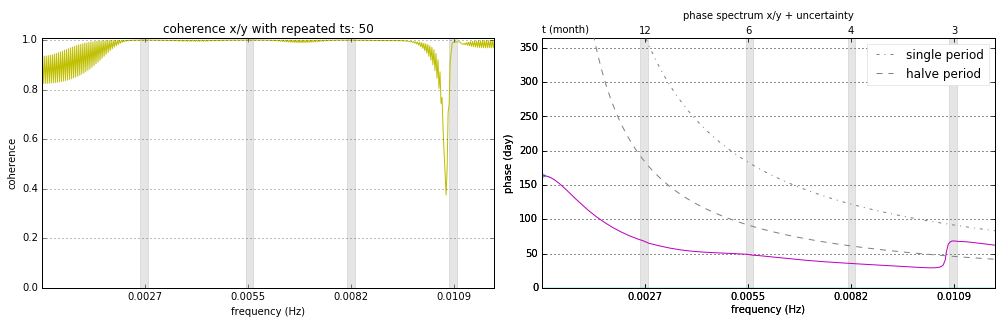

In [36]:
vspan_start = 0.0026
vspan_end = 0.0028
xlim_start = 0.000
xlim_end = 0.012#0.012
plotCrossSpectral(f,ph,coh,phif)

In [ ]:
# from the svi extract a single year and get the annual component
period = '2009'
y1_RC = svi_RC[period].as_matrix()[None]
y1_RC_HANTS = HANTS(y1_RC.shape[-1], y1_RC, 1, outliers_to_reject='Lo', low=-2000, 
                    high = 10000, fit_error_tolerance=500, base=1)
ts1_RC_period = pd.Series(y1_RC_HANTS[0], index=svi_RC[period].index)
ts1_RC_period.plot()